### See whether larger protests are more likely to succeed 

#### Trying to check if protests engaging more than X% of total population have more chances to succeed in final goal.

By calculating % of total pop for each protest and adding it as a new feature to a new dataframe

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from pylab import rcParams
import seaborn as sns
from matplotlib import pyplot as plt

#### Datasets

In [2]:
# 'NAVCO'
data_path = "C:/Users/diman/OneDrive/Desktop/HIT/YEAR_2/SEMESTER_2/Data_Science/project/datasets/NAVCO.xls"
data = pd.read_excel(data_path)

# 'World Population 1960-2018'
world_pop_path = "C:/Users/diman/OneDrive/Desktop/HIT/YEAR_2/SEMESTER_2/Data_Science/project/datasets/population.csv"
world_pop = pd.read_csv(world_pop_path)

#### merging dataframes to add total population column to each campaing

In [3]:
world_pop = world_pop.rename(columns={'Year': 'year', 'Country Name': 'location'}) # rename columns for easier merge
# create 'prot' to keep original dataframe
prot = pd.merge(data, world_pop) # merge the two datasets to get population per country for each year

In [4]:
prot.head() # protests df

,camp_name,id,year,campyearid,location,target,loc_iso,loc_cow,loc_vdem,territory,...,coding_notes,ra_initials,tccode,lccode,start_date_obsolete,end_date_obsolete,success,progress,outcomes_refs,Count
0,Active Forces,1,1991,1_1991,Madagascar,Didier Radsiraka,450.0,580.0,125.0,NaN,...,http://www.iss.org.za/pubs/papers/89/Paper89.h...,NaN,580.0,580.0,5/1/1991,2/10/1993,0,3,Gow 1997,11942819
1,Active Forces,1,1992,1_1992,Madagascar,Didier Radsiraka,450.0,580.0,125.0,NaN,...,Reuters lba0000020011123dobp03sm6 ; ;,NaN,580.0,580.0,5/1/1991,2/10/1993,0,3,Gow 1997,12301336
2,Active Forces,1,1993,1_1993,Madagascar,Didier Radsiraka,450.0,580.0,125.0,NaN,...,Reuters lba0000020011120dp6o06zif ; ;,NaN,580.0,580.0,5/1/1991,2/10/1993,1,4,NaN,12675460
3,Afar insurgency,2,1991,2_1991,Djibouti,Djibouti regime,262.0,522.0,113.0,NaN,...,; UCDP provides extensive coverage of the cam...,NaN,522.0,522.0,11/12/1991,26/12/1994,0,1,FRUD was able to take over large areas of the ...,606844
4,Afar insurgency,2,1992,2_1992,Djibouti,Djibouti regime,262.0,522.0,113.0,NaN,...,; UCDP provides extensive coverage of the cam...,NaN,522.0,522.0,11/12/1991,26/12/1994,0,2,"DJIBOUTI Human Rights Practices, 1992: Departm...",615054


new dataframe is going to contain the following features:
- `camp_name` - name of the campaign 
- `most_participants` - most participants 
- `total_population` - total population that year 
- `success` - did the campaign achieve its final goal 
- `location` - where the campaign occur 
- `perc_of_total` - participants % of total population 

####  `most_participants` feature

In [5]:
# filtering data to calculate most participants
prot = prot[prot.reliability != 1] # delete non reliable rows
prot['total_part'] = prot['total_part'].replace(-99,np.nan) # replace unknowns in total_part to NaNs
# total_part => most participants

# Look for each campaigns MAX of participants + few other features
# sorting the dataframe by total_part will help to find the largest total_part value for each campaign

most_part = prot.copy() # store max participants for each campaign
most_part = most_part.sort_values(by='total_part', ascending=False) # sort by most participants
most_part = most_part.drop_duplicates(subset=['camp_name'], keep='first') # keeps the row with the most participants per camp

most_part = most_part.dropna(subset=['total_part']) # drops rows with NaNs from total_part
most_part = most_part.loc[:, ['camp_name', # keep camp name
                              'total_part', # max participants
                              'Count', # number of total population in that year
                              'location', # where the protest happend
                              'year']] # what year the protest occur

#### `success` feature

In [6]:
# filter dataframe to get success column for each campaign
# df with 'camp name' & 'success'
succ = prot.copy()
succ = succ.sort_values(by='success', ascending=False) # [success = 1] rows going up
succ = succ.drop_duplicates(subset=['camp_name'], keep='first') # keep the row with [success = 1] first

succ = succ.loc[:, ['camp_name','success']] # keep only name and success features

#### Merging dataframes and creating `perc_of_total` feature

In [7]:
camp = pd.merge(succ, most_part) # contains: camp_name, success, total_part, Count, location

# calculating ( campaign size / total population ) percentage
# to see participants as percent of total population in that year

perc_of_total = [] # future column to camp df
perc = 0

# create new feature called 'perc_of_total'

# (max of participants / total population that year) * 100 [to show percentage]
for x in range(len(camp)): 
    perc = (camp.total_part.iloc[x] / camp.Count.iloc[x]) * 100 
    perc_of_total.append(perc) # adding each value to its camp_name index

camp['perc_of_total'] = perc_of_total # adding the new column

camp = camp.rename(columns={'total_part': 'most_participants', 'Count': 'total_population'}) # renaming

#### check for errors in new feature

In [8]:
camp[camp.perc_of_total>=100]

,camp_name,success,most_participants,total_population,location,year,perc_of_total
92,Singing Revolution,1,2000000.0,1568131,Estonia,1989,127.540365


looks like an error, but Estonia ended up with more than its population turning up for the 'Traditional singing day'

(people from other baltic republics would come to singing events in other countries)

---

### Using describe func `perc_of_total`

In [9]:
camp.perc_of_total.describe()

count    241.000000
mean       2.958548
std       11.413629
min        0.000032
25%        0.061419
50%        0.290777
75%        1.150894
max      127.540365
Name: perc_of_total, dtype: float64

going to save mean into `perc_mean`
### Seperate failed protests based on their % of total population 
select failed campaigns & seperate them by `perc_of_total < mean` & `perc_of_total > mean`

In [10]:
# saving the mean to perc_mean
perc_mean = camp.perc_of_total.mean() # perc_mean = 3

# find campaigns which ended with failure
fail_camp = camp[camp.success == 0] # 'fail_camp' - failed campaigns

# seperate between campaigns by perc_mean:

# campaigns in which the particpants number was smaller than 3% of total population
camp_low_perc = fail_camp[fail_camp.perc_of_total < perc_mean]

# campaigns in which the particpants number was greater than 3% of total population
camp_high_perc = fail_camp[fail_camp.perc_of_total > perc_mean] 

# save the number of campaigns in both dataframes
high_cnt = len(camp_high_perc) # number of campaigns with 'perc_of_total > 3'
low_cnt = len(camp_low_perc) # number of campaigns with 'perc_of_total < 3'

Now we have 2 groups of failed protests:
    - greater than 3% of population invovlved
    - less than 3% of  population involved
#### Piechart to show difference

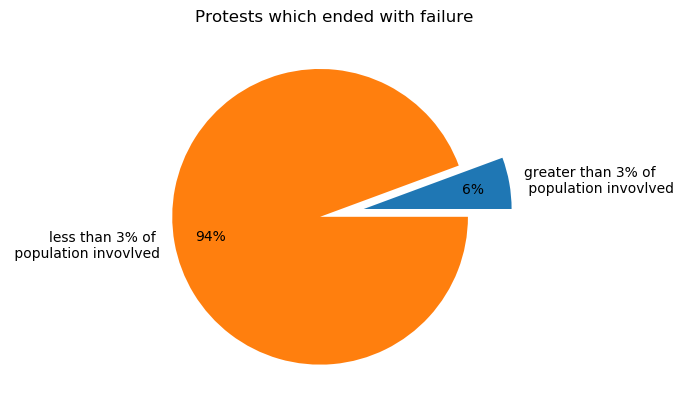

In [12]:
labels = ['greater than 3% of \n population invovlved',
          'less than 3% of \n population invovlved']

explode = [0.2,0.1] # for distance between the objects in plot

plt.pie([high_cnt,low_cnt], # the two categories of protests
        labels=labels,
        pctdistance=0.75, # 'X%' distance
        explode=explode, # distance between pies
        autopct='%.0f%%') # show percentage

plt.style.use('default')
plt.title("Protests which ended with failure")
plt.show()

### The pie chart shows that most of failed protests were less than 3% of total population 
is it possible that protests which involve higher than 3% of the population are less likely to fail?
 
 
---

Lets take a look at protests with greater than 3% of population and their success 

In [13]:
# seperate all capaigns by their success
# already have fail_camp, now create suc = successed campaigns
suc = camp.copy()
suc = suc[suc.success == 1] 

#### Visualize with plot for easier understanding
present a timeline from 1960 to 2013 showing successful and failed protests based on their % of population

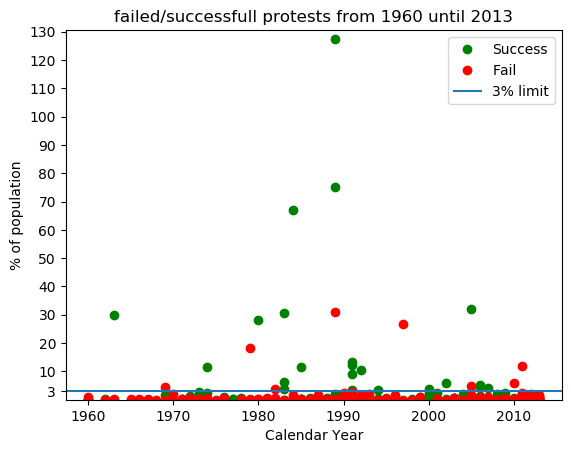

In [14]:
xticks = [1960,1970,1980,1990,2000,2010]
yticks = [3,10,20,30,40,50,60,70,80,90,100,110,120,130]

plt.plot(suc.year,suc.perc_of_total,# show perc_of_total for each year
         'go', # color and shape
         linestyle="", # no lines
         label='Success') # successed campaigns

plt.plot(fail_camp.year,fail_camp.perc_of_total,'ro',linestyle="",label='Fail') # same for failed campaigns

plt.axhline(y=3,label='3% limit') # 3% limit line
plt.ylim(0,camp.perc_of_total.max()+3) # Y axis limits
plt.title('failed/successfull protests from 1960 until 2013')
plt.xlabel('Calendar Year') # x lable
plt.ylabel('% of population') # y lable
plt.xticks(xticks) # x ticks
plt.yticks(yticks) # y ticks
plt.style.use('default') # set to default
plt.legend() 
plt.show()

- Most of failed protests had less than 3% of population, only few of them had more than 3%.

- Most of the protests with greater than 3% of population achieved final goal

#### So based on the data, a campaign has more chances to achieve success if the number of participants is higher than 3% of the total population.

---

##### Lets compare the current protests in the US with the data we have to see main differences

#### How much is 3% of US population?

According to [worldometer](https://www.worldometers.info/world-population/us-population/), 
US total population is aprox. 331,000,000, therefore 3% is around 9,900,000 protestors.

#### Is it even possible to compare with the rest of the protests?

The rise of social media has made protests more accessable, unbiased and immediate. Movements can now spread at very high speeds. If we count the activism in social media, the number of participants may be surprisingly high:


- BLM movement worldwide - 5,000,000
- Pew Research found that *#BlackLivesMatter* hashtag has been used roughly **47,800,000** times on Twitter
- The social media streaming app TikTok has recently surpassed **10,500,000,000** views on the *#BlackLivesMatter* hashtag.

In [15]:
# making a row for current protests in USA

usa_most_participants = 10**10 # 10 billion
usa_total_pop = 331000000

# most_participants / total_population * 100 to show in %
usa_perc = (usa_most_participants / usa_total_pop) * 100 # perc of total

usa = {'camp_name':'George Floyd and Black Lives Matter Movement Worldwide', # name
       'success':2, # still going
       'most_participants':usa_most_participants, # participants
       'total_population':usa_total_pop, # total population
       'location':'Worldwide', # location
       'year':2020,
       'perc_of_total': usa_perc
      }

#append row to dataframe
camp_b = camp.copy()
camp_b = camp_b.append(usa, ignore_index=True)

The new added protest has a very high ammount of participants
#### It easily goes to top 1 if we sort by `most_participants` or  `perc_of_total`

In [16]:
camp_b.sort_values(by=['most_participants'],ascending=False).head()

,camp_name,success,most_participants,total_population,location,year,perc_of_total
241,George Floyd and Black Lives Matter Movement W...,2,1.000000e+10,331000000,Worldwide,2020,3021.148036
98,Solidarity,1,1.000000e+07,35574150,Poland,1980,28.110299
30,Argentina pro-democracy movement,1,9.000000e+06,29262047,Argentina,1983,30.756563
94,South Africa Second Defiance Campaign,1,4.000000e+06,38672607,South Africa,1992,10.343239
3,Nigeria Anti-Military,1,3.500000e+06,105293700,Nigeria,1994,3.324036


#### Plot of a timeline with max number of participants in campaings

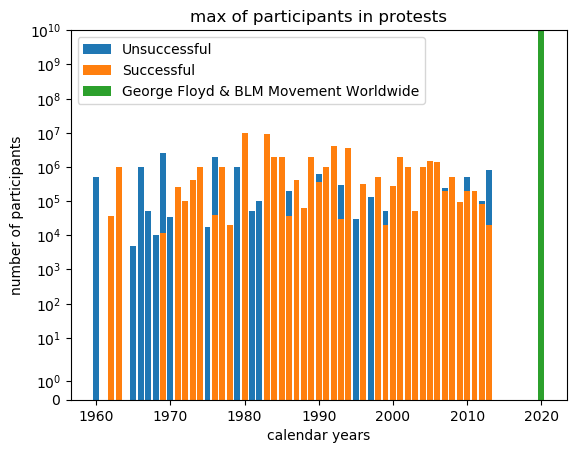

In [17]:
only_usa = camp_b[camp_b.camp_name == 'George Floyd and Black Lives Matter Movement Worldwide'] # to make different color

plt.bar(fail_camp.year, fail_camp.most_participants,label = 'Unsuccessful')
plt.bar(suc.year, suc.most_participants, label='Successful')
plt.bar(only_usa.year, only_usa.most_participants,label="George Floyd & BLM Movement Worldwide")
plt.yscale('symlog',basey=10)
plt.title("max of participants in protests")
plt.ylabel('number of participants')
plt.xlabel('calendar years')
plt.legend()
plt.ylim(0,camp_b.most_participants.max())
plt.style.use('default') # set to default
plt.show()

Note that the Y axis scale is 'symlog' with base 10, the difference is almost uncomparable.

---

### just a simple visualization of protests throughout the years to show difference in sizes of protests

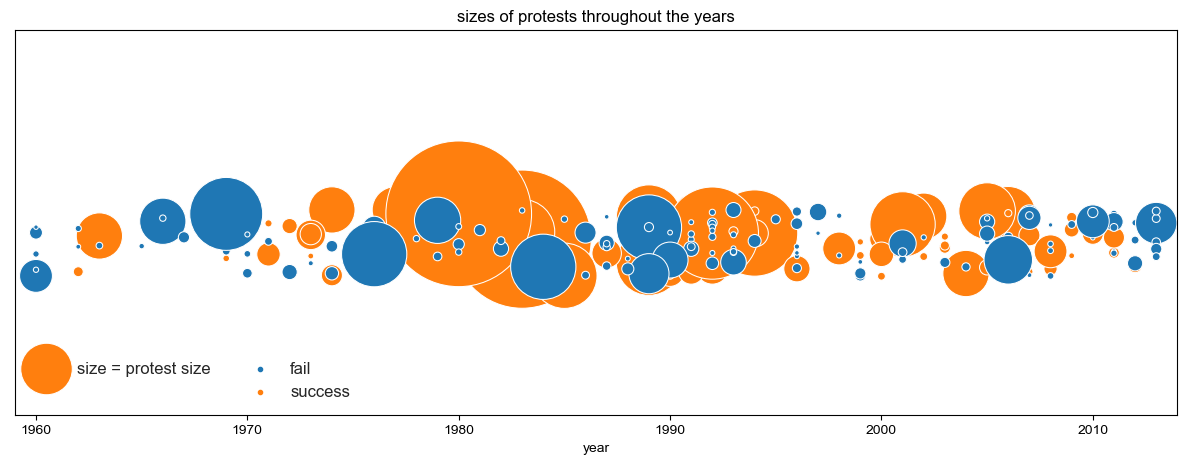

In [18]:
fig = plt.figure(figsize=(20, 5))
fig.set_size_inches(15,5)
# sns.set_style('ticks')
labels = ['size = protest size','','fail','success']
camp['randNumCol'] = np.random.uniform(0.1, 0.16, len(camp)) # generate dummy feature with random floats to use in the plot

# plot
chart = sns.scatterplot(x = 'year', # X axis = year
                        y = 'randNumCol', # Y axis = random float (just for the visualization)
                        hue ='success', # color = success/failure
                        size="most_participants", # size = campaign size
                        sizes=(10, 11000), # sizes limits
                        data=camp)

sns.set_style('ticks') # style
plt.xlim(1959,2014) # X limits
plt.title('sizes of protests throughout the years')
plt.ylabel('') # hide y label
plt.yticks([]) # hide y axis
plt.legend(loc=3, # legend location
           labels=labels, 
           fontsize='large',
           markerscale=0.5, # legend marker size
           frameon=0, # legend frame off
           ncol=2) # legend cols = 2
plt.show()